# Пикник в Москве

## Intro

Что делают программисты? Правильно, они делают понятные вещи странными способами.

Смотрят в окно, например: https://www.isitdarkoutside.com

Попробуем узнать, где в Москве лучше всего устроить летний пикник.

Но вместо того, чтобы спрашивать друзей и гулять по окрестностям, попробуем сделать это аналитически.

In [1]:
import json
import numpy as np
import requests

## Получим данные

Документация: https://apidata.mos.ru/Docs

Получить токен: https://apidata.mos.ru/Account/Login

In [2]:
# TODO получить токен с mos.ru, положить его в правильный файл и скачать датасет 
with open('./token.txt', 'r') as token:
    apiKey = token.read()

req_template = 'https://apidata.mos.ru/v1/{}/?api_key={}'
dataset_path = 'datasets/912/rows'  # это датасет про все места для пикников в Москве

response = requests.get(req_template.format(dataset_path, apiKey))

In [3]:
data = response.json()

In [4]:
response, len(data)

(<Response [200]>, 156)

In [5]:
data[0]

{'Cells': {'Address': 'Алтуфьевское шоссе, дом 94',
  'AdmArea': 'Северо-Восточный административный округ',
  'ClarificationOfWorkingHoursWinter': None,
  'DimensionsWinter': [],
  'DisabilityFriendly': 'не приспособлен',
  'District': 'район Бибирево',
  'Email': 'leshoz_sewer@mail.ru',
  'EquipmentRentalComments': None,
  'HasCashMachine': 'нет',
  'HasDressingRoom': 'нет',
  'HasEatery': 'нет',
  'HasEquipmentRental': 'нет',
  'HasFirstAidPost': 'нет',
  'HasMusic': 'нет',
  'HasTechService': 'нет',
  'HasToilet': 'да',
  'HasWifi': 'нет',
  'HelpPhone': '(495) 579-29-76',
  'HelpPhoneExtension': None,
  'Lighting': 'без дополнительного освещения',
  'NameWinter': None,
  'ObjectName': 'Планируемый к созданию Комплексный заказник Алтуфьевский',
  'Paid': 'бесплатно',
  'PaidComments': None,
  'PhotoWinter': [],
  'Seats': 0,
  'ServicesWinter': [],
  'SurfaceTypeWinter': None,
  'TechServiceComments': None,
  'UsagePeriodWinter': None,
  'WebSite': 'www.dpioos.ru',
  'WorkingHoursWi

Отлично, у нас есть данные про 156 потенциальных мест для пикника в таком формате

Сохраним это куда-нибудь.

In [6]:
with open('picnic.json', 'w') as f:
    json.dump(data, f)

## Изучим данные

In [7]:
picnic_data = [row['Cells'] for row in data]

print('Всего мест', len(picnic_data))

Всего мест 156


In [8]:
picnic_data[0]

{'Address': 'Алтуфьевское шоссе, дом 94',
 'AdmArea': 'Северо-Восточный административный округ',
 'ClarificationOfWorkingHoursWinter': None,
 'DimensionsWinter': [],
 'DisabilityFriendly': 'не приспособлен',
 'District': 'район Бибирево',
 'Email': 'leshoz_sewer@mail.ru',
 'EquipmentRentalComments': None,
 'HasCashMachine': 'нет',
 'HasDressingRoom': 'нет',
 'HasEatery': 'нет',
 'HasEquipmentRental': 'нет',
 'HasFirstAidPost': 'нет',
 'HasMusic': 'нет',
 'HasTechService': 'нет',
 'HasToilet': 'да',
 'HasWifi': 'нет',
 'HelpPhone': '(495) 579-29-76',
 'HelpPhoneExtension': None,
 'Lighting': 'без дополнительного освещения',
 'NameWinter': None,
 'ObjectName': 'Планируемый к созданию Комплексный заказник Алтуфьевский',
 'Paid': 'бесплатно',
 'PaidComments': None,
 'PhotoWinter': [],
 'Seats': 0,
 'ServicesWinter': [],
 'SurfaceTypeWinter': None,
 'TechServiceComments': None,
 'UsagePeriodWinter': None,
 'WebSite': 'www.dpioos.ru',
 'WorkingHoursWinter': [],
 'geoData': {'coordinates': [3

Итак, у нас есть данные про (навскидку):
* координаты места
* его имя, адрес и всякие контакты (веб-сайт, район москвы, ...)
* его свойства (наличие wifi, туалетов, ...)

Важно понимать, что эти данные есть не всегда. 

Например, для Алтуфьевского заказника нет никакой информации про его работу зимой.

## Проверим полноту данных

Перед тем, как делать выводы из имеющихся данных, полезно посмотреть на их полноту.

Вдруг мы анализируем информацию, которой у нас вообще нет?

In [9]:
for field in picnic_data[0].keys():
    picnics_without_field = sum([1 for picnic in picnic_data if picnic[field] is None])
    if picnics_without_field > 0:
        print('Поле {} не заполнено у {} мест'.format(field, picnics_without_field))

Поле UsagePeriodWinter не заполнено у 30 мест
Поле HelpPhoneExtension не заполнено у 156 мест
Поле PaidComments не заполнено у 156 мест
Поле ClarificationOfWorkingHoursWinter не заполнено у 156 мест
Поле DisabilityFriendly не заполнено у 10 мест
Поле Email не заполнено у 2 мест
Поле NameWinter не заполнено у 30 мест
Поле TechServiceComments не заполнено у 156 мест
Поле SurfaceTypeWinter не заполнено у 30 мест
Поле EquipmentRentalComments не заполнено у 156 мест


Поскольку у нас всего 156 мест, то можно понимать, какими полями интересоваться в принципе бесполезно.

# Преобразуем данные

```'HasWifi': 'нет'```

Не очень удобный формат для работы.
Строки ```"да"/"нет"``` лучше представить как логические (булевы) переменные (```True/False```).

Так:

1) данные будут занимать меньше места, т.к. строка ```"нет"``` занимает больше памяти, чем ```False```;

2) с данными будет удобнее работать.

Для этого:
* определите все поля, которые можно представить булевыми переменными;
* перезапишите значения этих полей.

In [10]:
# TODO бинаризовать данные
boolean_fields = (
    'HasCashMachine',
    'HasDressingRoom',
    'HasEatery',
    'HasEquipmentRental',
    'HasFirstAidPost',
    'HasMusic',
    'HasTechService',
    'HasToilet',
    'HasWifi'
)

In [11]:
for picnic in picnic_data:
    for field in boolean_fields:
        picnic[field] = picnic[field] == 'да'

In [12]:
picnic_data[0]

{'Address': 'Алтуфьевское шоссе, дом 94',
 'AdmArea': 'Северо-Восточный административный округ',
 'ClarificationOfWorkingHoursWinter': None,
 'DimensionsWinter': [],
 'DisabilityFriendly': 'не приспособлен',
 'District': 'район Бибирево',
 'Email': 'leshoz_sewer@mail.ru',
 'EquipmentRentalComments': None,
 'HasCashMachine': False,
 'HasDressingRoom': False,
 'HasEatery': False,
 'HasEquipmentRental': False,
 'HasFirstAidPost': False,
 'HasMusic': False,
 'HasTechService': False,
 'HasToilet': True,
 'HasWifi': False,
 'HelpPhone': '(495) 579-29-76',
 'HelpPhoneExtension': None,
 'Lighting': 'без дополнительного освещения',
 'NameWinter': None,
 'ObjectName': 'Планируемый к созданию Комплексный заказник Алтуфьевский',
 'Paid': 'бесплатно',
 'PaidComments': None,
 'PhotoWinter': [],
 'Seats': 0,
 'ServicesWinter': [],
 'SurfaceTypeWinter': None,
 'TechServiceComments': None,
 'UsagePeriodWinter': None,
 'WebSite': 'www.dpioos.ru',
 'WorkingHoursWinter': [],
 'geoData': {'coordinates': [3

In [13]:
if not picnic_data[0]['HasWifi']:  # куда красивее, чем picnic_data[0]['HasWifi'] == 'нет'
    print('В {} нет Wifi... :('.format(picnic_data[0]['ObjectName']))

В Планируемый к созданию Комплексный заказник Алтуфьевский нет Wifi... :(


Ещё можно бы удалить поля, которые нам не очень интересны (любая информация про зиму не нужна в контексте летнего пикника).

Но сейчас не будем.

С булевыми полями всё ясно, а какие варианты бывают у "Paid"?

In [14]:
set([picnic['Paid'] for picnic in picnic_data])

{'бесплатно'}

Хм, не очень интересно..

Кстати, та же история с Lighting -- нигде нет дополнительного освещения. :(

In [15]:
set([(picnic['WebSite'], picnic['Email']) for picnic in picnic_data])

{('chertanovo-juzhnoe.mos.ru', None),
 ('kuzpark.ru', 'dir-yuvao@eco.mos.ru'),
 ('mosecovao.info', 'ooptvao@gmail.com'),
 ('mospriroda.ru', 'formulasporta@yandex.ru'),
 ('mospriroda.ru', 'mospriroda@eco.mos.ru'),
 ('ooptsvao.mos.ru', 'dir-svao@eco.mos.ru'),
 ('otradnoe.mos.ru', 'mosportotr@mail.ru'),
 ('otradnoe.mos.ru', None),
 ('svao.mos.ru', 'leshoz_sewer@mail.ru'),
 ('uooptzao.ru', 'uoopt.zao@gmail.com'),
 ('www.dpioos.ru', 'leshoz_sewer@mail.ru'),
 ('www.dpioos.ru/eco/ru/oopt/o_1008', 'oopt.uao@gmail.com'),
 ('www.dpioos.ru/eco/ru/oopt/o_1212', 'gpbu@oopt-szao.ru'),
 ('www.mosecovao.info/vao_eco/ru', 'ooptvao@gmail.com'),
 ('www.mospriroda.ru', 'gpbu@oopt-szao.ru'),
 ('www.mospriroda.ru', 'leshoz_sewer@mail.ru'),
 ('www.mospriroda.ru', 'mospriroda@eco.mos.ru'),
 ('www.mospriroda.ru', 'ooptvao@gmail.com'),
 ('www.oopt-kurkino.ru', 'mospriroda@eco.mos.ru')}

Т.к. поле ```WebSite``` было заполнено у всех мест, то ясно, что разнообразия в веб-сайтах нет.

# Займёмся делом
## То есть порисуем красивые картинки

Самая простая инфографика -- просто диаграммы со статистиками про разные свойства мест для пикника.

Посмотрим, насколько Москва в принципе обустроена.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline  # это нужно, чтобы графики рисовались прямо в ноутбуке
plt.rcParams.update({'font.size': 20})

UsageError: unrecognized arguments: # это нужно, чтобы графики рисовались прямо в ноутбуке


In [21]:
properties = (
    'HasCashMachine',
    'HasEatery',
    'HasFirstAidPost',
    'HasMusic',
    'HasToilet',
    'HasWifi'
)

In [22]:
picnic_data[0]

{'Address': 'Алтуфьевское шоссе, дом 94',
 'AdmArea': 'Северо-Восточный административный округ',
 'ClarificationOfWorkingHoursWinter': None,
 'DimensionsWinter': [],
 'DisabilityFriendly': 'не приспособлен',
 'District': 'район Бибирево',
 'Email': 'leshoz_sewer@mail.ru',
 'EquipmentRentalComments': None,
 'HasCashMachine': False,
 'HasDressingRoom': False,
 'HasEatery': False,
 'HasEquipmentRental': False,
 'HasFirstAidPost': False,
 'HasMusic': False,
 'HasTechService': False,
 'HasToilet': True,
 'HasWifi': False,
 'HelpPhone': '(495) 579-29-76',
 'HelpPhoneExtension': None,
 'Lighting': 'без дополнительного освещения',
 'NameWinter': None,
 'ObjectName': 'Планируемый к созданию Комплексный заказник Алтуфьевский',
 'Paid': 'бесплатно',
 'PaidComments': None,
 'PhotoWinter': [],
 'Seats': 0,
 'ServicesWinter': [],
 'SurfaceTypeWinter': None,
 'TechServiceComments': None,
 'UsagePeriodWinter': None,
 'WebSite': 'www.dpioos.ru',
 'WorkingHoursWinter': [],
 'geoData': {'coordinates': [3

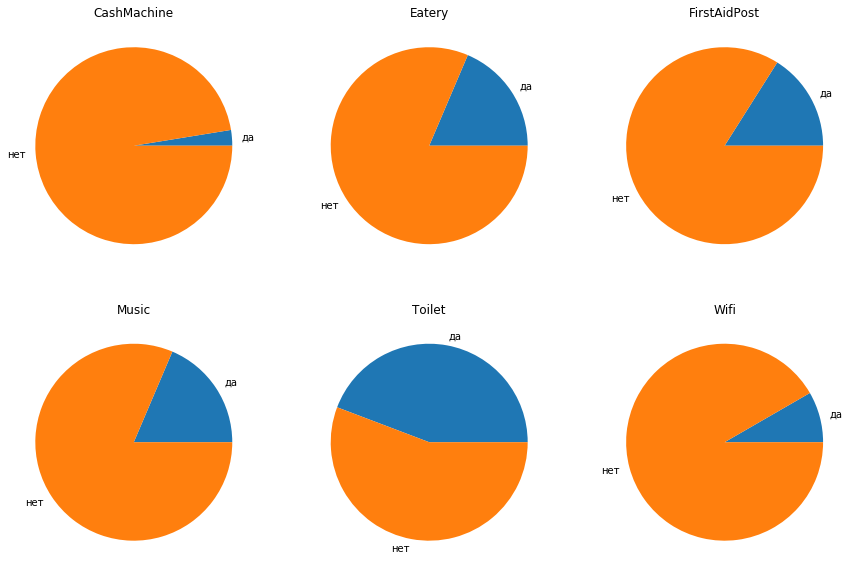

In [23]:
fig, axes= plt.subplots(2, 3, figsize=(15,10))
total = len(picnic_data)

for i, ax in enumerate(axes.flatten()):
    picnic_property = properties[i]
    has_property = sum(1 for picnic in picnic_data if picnic[picnic_property])
    ax.pie([has_property, total - has_property], labels=['да', 'нет'], radius=1, pctdistance=0.9)
    ax.set_title(picnic_property[3:])

plt.show()

По районам:

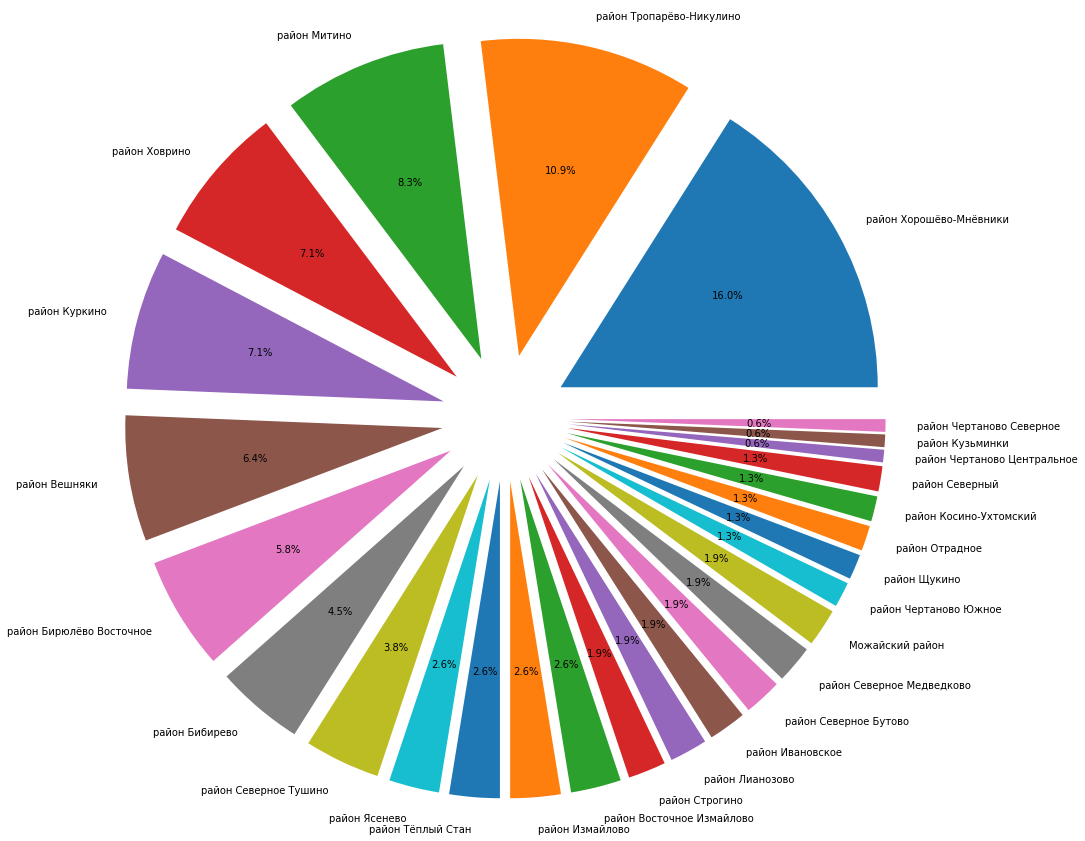

In [24]:
fig1, ax1 = plt.subplots(figsize=(15, 15))

labels = set([picnic['District'] for picnic in picnic_data])
sizes = [sum([1 for picnic in picnic_data if picnic['District'] == label]) for label in labels]

# отсортируем по количеству мест для пикника в районе
labels, sizes = zip(*sorted(zip(labels, sizes), key=lambda x: x[1], reverse=True))

ax1.pie(sizes, labels=labels, explode=[0.2] * len(labels), autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


Посмотрим на координаты мест для пикника.

In [25]:
# TODO: подставьте координаты своего дома. Узнать их можно, например, в Яндекс.Картах.
my_coords = [37.663288, 55.766734]  # HSE

In [26]:
def plot_picnic(data, where_am_i=my_coords):
    plt.rcParams.update({'font.size': 20})
    
    points = np.array([picnic['geoData']['coordinates'] for picnic in data])

    plt.figure(figsize=(10,7))
    plt.plot(points[:,0], points[:,1], 'o', markersize=7, color='gray')
    plt.plot(*where_am_i, 'v', markersize=10, color='black')
    plt.annotate('я тут!', xy=where_am_i, xytext=(-15, -20), textcoords='offset points')
    plt.grid(True)
    plt.xlabel('долгота')
    plt.ylabel('широта')
    plt.show()

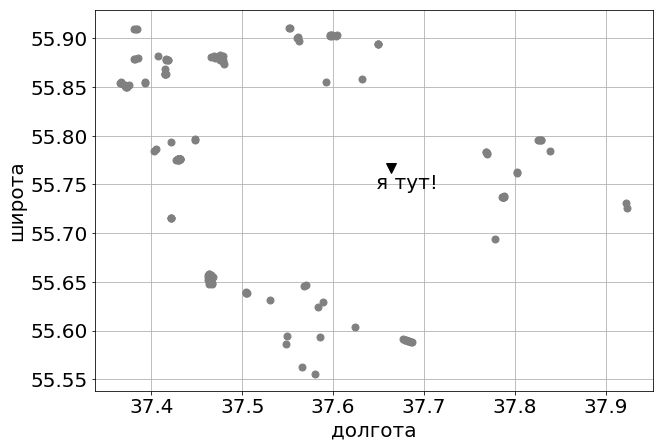

In [27]:
plot_picnic(picnic_data)

Как-то нам не повезло -- все парки довольно далеко.

Не очень ясно, какой парк ближе, да и всё серое. Давайте раскрасим эту картинку!

In [28]:
import matplotlib.cm as cm

def plot_picnic_colored(data, where_am_i=my_coords):
    plt.rcParams.update({'font.size': 20})
    
    titles = np.array([picnic['Address'] for picnic in data])
    points = np.array([picnic['geoData']['coordinates'] for picnic in data])
    # получим расстояния
    distances = [np.linalg.norm(point - where_am_i) for point in points]
    # нормализуем их, чтобы было красивое распределение
    distances_norm = [(distance - min(distances)) / (max(distances) - min(distances)) for distance in distances]
    # и нормализованные цвета для них, чем краснее -- тем ближе
    colors = map(cm.autumn, distances_norm)
    
    plt.figure(figsize=(10,7))
    for point, color, title in zip(points, colors, titles):
        plt.plot(*point, 'o', markersize=7, color=color)
    plt.plot(*where_am_i, 'v', markersize=10, color='black')
    plt.annotate('я тут!', xy=where_am_i, xytext=(-15, -20), textcoords='offset points')
    plt.grid(True)
    plt.xlabel('долгота')
    plt.ylabel('широта')
    plt.show()

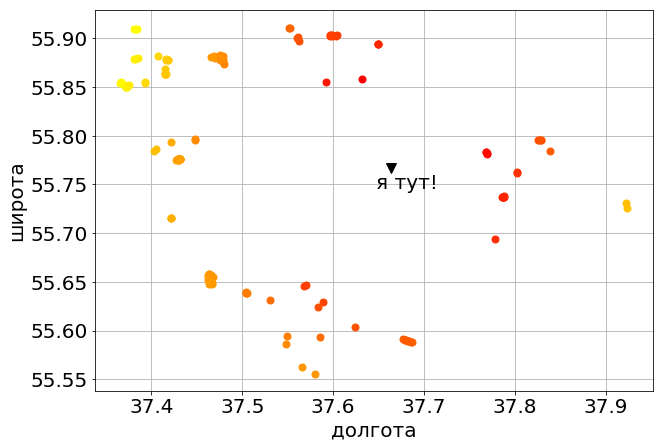

In [29]:
plot_picnic_colored(picnic_data)

Давайте научимся фильтровать места для пикника по каким-то свойствам!

In [30]:
import matplotlib.cm as cm

def plot_only_good_picnic(data, condition=lambda x: True, where_am_i=my_coords):
    plt.rcParams.update({'font.size': 20})
    
    data = [picnic for picnic in data if condition(picnic) == True]
    plot_picnic_colored(data, where_am_i)

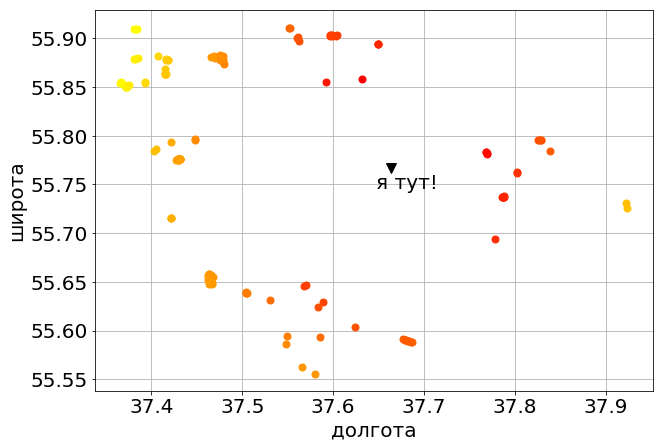

In [31]:
plot_only_good_picnic(picnic_data)

In [32]:
def has_toilet(place):
    return place['HasToilet']

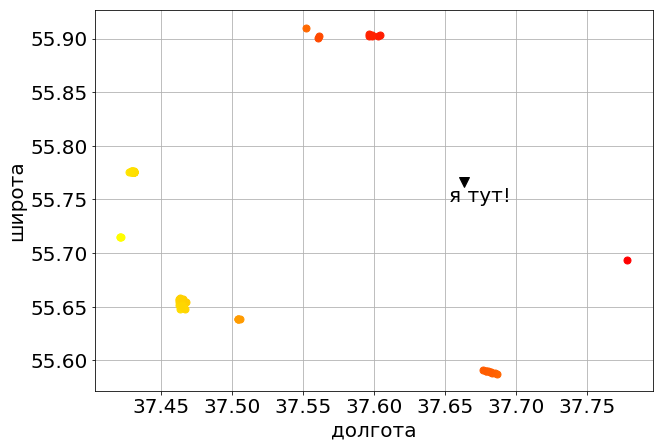

In [33]:
plot_only_good_picnic(picnic_data, condition=has_toilet)

In [34]:
def has_music_and_food(place):
    return place['HasMusic'] and place['HasEatery']

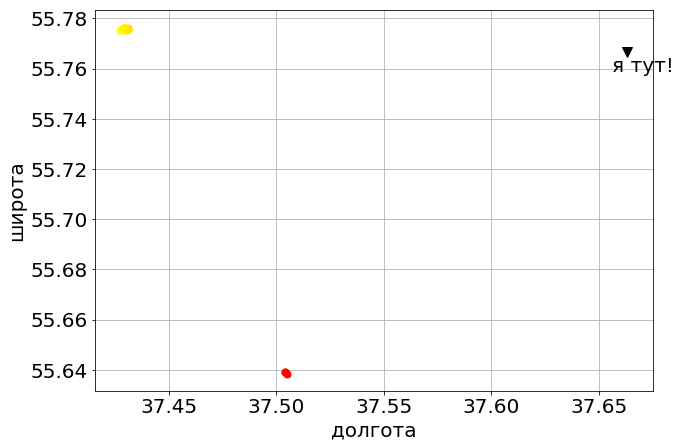

In [35]:
plot_only_good_picnic(picnic_data, condition=has_music_and_food)

## Дополнительные идеи

* подписать на карте адрес/название у 3 ближайших парков
* составить другие условия (как has_music_and_food)
* . . . anything!